In [1]:
%pylab inline
from scipy.stats import norm

Populating the interactive namespace from numpy and matplotlib


# Functions

In [2]:
def sigma(x):
    return norm.pdf(x)

def PHI(x):
    return norm.cdf(x)

def N(x):
    return x*PHI(x)+sigma(x)
def M(x):
    return (1+pow(x,2))*PHI(x)+x*sigma(x)    

def Nprime(x):
    return PHI(x)

def F(u,uprime,utilde,gamma,g,w):
    return -2*g*gamma*PHI(u)*uprime-2*g*N(u)+utilde-w

def wstar(g):
    x=1.0/(2.0*g)
    return -2*g*N(norm.ppf(x))+norm.ppf(x)

# DDE numerical integrator

In [5]:
#CONVENTIONS:
#w<0 ; Deltax >0 ; u0 <0 ; x0<0

def Integrate_u(g,w,gamma,Deltax,u0,x0,resolution_density=100):
    xmax=2*abs(x0)
    resolution=2*abs(x0)*resolution_density
    u_old=u0
    up_old=0
    x=np.linspace(x0,xmax,resolution)
    Dr=abs(xmax-x0)/resolution
    solution=np.zeros(len(x))
    derivative=np.zeros(len(x))
    solution[:int(resolution*Deltax/(xmax-x0))]=u0
    derivative[:int(resolution*Deltax/(xmax-x0))]=0
    for i in range(int((Deltax)*resolution/(xmax-x0)),2*int((Deltax)*resolution/(xmax-x0))):
        solution[i]=u_old
        derivative[i]=up_old
        a=F(u0,0,u_old,gamma,g,w)
        up_new=up_old+(a)*Dr
        u_new=u_old+(up_new)*Dr
        u_old=u_new
        up_old=up_new
        
    Di=int(Deltax*resolution/(xmax-x0))
    for i in range(2*int((Deltax)*resolution/(xmax-x0)),len(x)):
        solution[i]=u_old
        derivative[i]=up_old
        a=F(solution[i-Di],derivative[i-Di],u_old,gamma,g,w)
        up_new=up_old+(a)*Dr
        u_new=u_old+(up_new)*Dr
        u_old=u_new
        up_old=up_new
    
    #solution[solution<u0]=u0
    return solution,derivative

def u_profile(g,w,gamma,Deltax,u0,x0,resolution_density=100):
    xmax=2*abs(x0)
    resolution=2*abs(x0)*resolution_density
    u_old=u0
    up_old=0
    x=np.linspace(x0,xmax,resolution)
    Dr=abs(xmax-x0)/resolution
    solution=np.zeros(len(x))
    derivative=np.zeros(len(x))
    solution[:int(resolution*Deltax/(xmax-x0))]=u0
    derivative[:int(resolution*Deltax/(xmax-x0))]=0
    for i in range(int((Deltax)*resolution/(xmax-x0)),2*int((Deltax)*resolution/(xmax-x0))):
        solution[i]=u_old
        derivative[i]=up_old
        a=F(u0,0,u_old,gamma,g,w)
        up_new=up_old+(a)*Dr
        u_new=u_old+(up_new)*Dr
        u_old=u_new
        up_old=up_new
        
    Di=int(Deltax*resolution/(xmax-x0))
    for i in range(2*int((Deltax)*resolution/(xmax-x0)),len(x)):
        solution[i]=u_old
        derivative[i]=up_old
        a=F(solution[i-Di],derivative[i-Di],u_old,gamma,g,w)
        up_new=up_old+(a)*Dr
        u_new=u_old+(up_new)*Dr
        u_old=u_new
        up_old=up_new
        
    mins_and_maxs=[i for i in range(len(derivative[1:])) if derivative[i-1]*derivative[i]<0]
    if len(mins_and_maxs)>1:
        solution[mins_and_maxs[1]:]=u0
        
    
    solution[solution<u0]=u0
        
    solution=roll(solution,int(len(solution)/2)-argmax(solution))

    return solution

def find_u0(g,w,x0,precision=0.01):
    low=wstar(g)-5
    high=0
    
    count=0
    gamma=0
    Deltax=0
    converged=False
    
    while not converged:
        midpoint=(high+low)/2.0
        u0=midpoint
        u,du=Integrate_u(g,w,gamma,Deltax,u0,x0)
        if u[-1]<u0 and np.asarray([du[int(len(du)/2):]<0]).all():
            low=midpoint   
        else:
            high=midpoint
            
        converged=(abs(u[-1]-u0)<precision) or count>200
        count=count+1
        
    if count>200:
        print("Not converged!")
        
    
    return u[-1]

def find_Deltax(g,w,gamma,u0,x0,precision=0.001):
    low=0
    high=gamma+0.1
    
    converged=False
    count=0
    Deltax_old=0
    while not converged:
        midpoint=(high+low)/2.0
        Deltax=midpoint
        u,du=Integrate_u(g,w,gamma,Deltax,u0,x0)
        if u[-1]<u0 and np.asarray([du[int(len(du)/2):]<0]).all():
            high=midpoint 
        else:
            low=midpoint
            
        converged=(abs(Deltax-Deltax_old)<precision) or count>200
        
        Deltax_old=Deltax
        count=count+1
    if count>200:
        print("Not converged!")
        
    return Deltax

# Solution in a range of $g$, $w$ and $\gamma$

In [ ]:
x0=-10 #size of the environment=30
raw_u=np.zeros((5,5,5,2000))
raw_du=np.zeros((5,5,5,2000))
corrected_u=np.zeros((5,5,5,2000))
Deltas=np.zeros((5,5,5))
gammas=linspace(0,2,5)
gs=linspace(0.7,3,5)
for i in range(len(gammas)):
    for j in range(len(gs)):
        ws=wstar(gs[j])+linspace(-3,-0.1,5)
        for k in range(len(ws)):
            print("Calculating profile for: gamma="+str(gammas[i])+" g="+str(gs[j])+" w="+str(ws[k]))
            w=ws[k]
            g=gs[j]
            gamma=gammas[i]
            u0=find_u0(g,w,x0)
            Deltax=find_Deltax(g,w,gamma,u0,x0)
            Deltas[i][j][k]=Deltax
            Deltax_corrected=Deltax+0.1*Deltax
            corrected_u[i][j][k][:]=u_profile(g,w,gamma,Deltax_corrected,u0,x0)
            raw_u[i][j][k][:],raw_du[i][j][k][:]=Integrate_u(g,w,gamma,Deltax,u0,x0)
            print("Done. "+str(k+j*len(gs)+i*len(gs)*len(gammas))+"/"+str(len(gammas)*len(gs)*len(ws))+" completed")



In [43]:
# SAVES DATA
'''
np.save("raw_u",raw_u)
np.save("raw_du",raw_du)
np.save("corrected_u",corrected_u)
np.save("Deltas",Deltas)
'''

# Activity plotter

In [8]:
#corrected_u=np.load("corrected_u.npy")

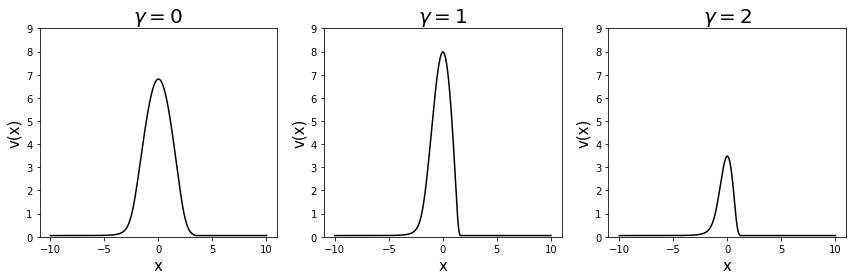

In [10]:
j=0
k=3
x=linspace(-10,10,len(corrected_u[0][0][0]))
figure(figsize=(12,4))
subplot(1,3,1)
plot(x,N(corrected_u[0][j][k]),c="k")
ylim(0,9)
title(r"$\gamma=0$",fontsize=20)
xlabel("x",fontsize=15)
ylabel("v(x)",fontsize=15)
subplot(1,3,2)
plot(x,N(corrected_u[2][j][k]),c="k")
ylim(0,9)
title(r"$\gamma=1$",fontsize=20)
xlabel("x",fontsize=15)
ylabel("v(x)",fontsize=15)
subplot(1,3,3)
plot(x,N(corrected_u[4][j][k]),c="k")
ylim(0,9)
title(r"$\gamma=2$",fontsize=20)
xlabel("x",fontsize=15)
ylabel("v(x)",fontsize=15)
tight_layout()
savefig("v_profiles.eps")